### Collecting the dataset using webcam

In [ ]:
import cv2
import numpy as np
import os
import mediapipe as mp

# Define dataset path
DATA_PATH = "SignLanguageDataset"
actions = np.array(["Hello", "Yes", "No", "Please", "ThankYou", "Mother", "Father", "Love", "Baby", "Sorry", "You're welcome"])

sequence_length = 30  # Number of frames per sequence
num_sequences = 60  # Number of sequences per action

# Initialize MediaPipe
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Create directories
for action in actions:
    os.makedirs(os.path.join(DATA_PATH, action), exist_ok=True)

# Function to extract keypoints from the frame
def extract_landmarks(image, holistic):
    """Extract hand and pose landmarks using MediaPipe"""
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = holistic.process(img_rgb)

    # Extract keypoints
    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]) if results.pose_landmarks else np.zeros((33, 3))
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21, 3))
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros((21, 3))

    return np.concatenate([pose.flatten(), left_hand.flatten(), right_hand.flatten()])

# Open webcam
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(120,180):
            print(f"📷 Recording {action} - Sequence {sequence + 1}/{num_sequences}")

            # Wait before starting recording
            for frame in range(5):
                ret, frame = cap.read()
                cv2.putText(frame, f"GET READY: {action}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.imshow("Webcam", frame)
                cv2.waitKey(1000)

            # Collect sequence data
            for frame_idx in range(sequence_length):
                ret, frame = cap.read()

                # Extract keypoints
                keypoints = extract_landmarks(frame, holistic)
                print(f"Extracted Keypoints: {keypoints.shape}") 

                # Save keypoints
                keypoints_path = os.path.join(DATA_PATH, action, f"{sequence}_{frame_idx}.npy")
                np.save(keypoints_path, keypoints)

                # Show frame with landmarks
                mp_drawing.draw_landmarks(frame, holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).pose_landmarks, mp_holistic.POSE_CONNECTIONS)
                cv2.putText(frame, f"Collecting {action} | sequence {sequence} | Frame {frame_idx + 1}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.imshow("Webcam", frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

cap.release()
cv2.destroyAllWindows()

print("Data collection complete! All keypoints saved.")


In [ ]:
cap.release()
cv2.destroyAllWindows()

### Pre-processing the collected data

In [5]:
import numpy as np
import os

# Define dataset path
DATA_PATH = "SignLanguageDataset"

# Parameters
num_sequences = 60  # Number of sequences per action
sequence_length = 30  # Number of frames per sequence
actions = np.array(["Hello", "Yes", "No", "Please", "ThankYou", "Mother", "Father", "Love", "Baby", "Sorry"])

# Load data
X, Y = [], []
for action_idx, action in enumerate(actions):
    for sequence in range(num_sequences):  # Assume 100 sequences per action
        sequence_data = []
        for frame in range(sequence_length):
            keypoints_path = os.path.join(DATA_PATH, action, f"{sequence}_{frame}.npy")
            keypoints = np.load(keypoints_path)  # Load keypoint data
            sequence_data.append(keypoints)
        X.append(sequence_data)
        Y.append(action_idx)

# Convert to NumPy arrays
X = np.array(X)
Y = np.array(Y)

# Save processed data
np.save("X_sequences.npy", X)
np.save("Y_labels.npy", Y)

print("Data preprocessing complete!")


Data preprocessing complete!


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.model_selection import train_test_split

# Load processed data
X = np.load("X_sequences.npy")
Y = np.load("Y_labels.npy")

# One-hot encode labels
Y = tf.keras.utils.to_categorical(Y, num_classes=len(set(Y)))

# Split dataset
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

### Create the model and training

In [ ]:

# Define LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(128, return_sequences=True, activation='relu'),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(set(Y.argmax(axis=1))), activation='softmax')  # Output layer (one neuron per gesture)
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val))

# Save model
model.save("lstm_sign_language_model_5.keras", save_format="keras")
print("LSTM model training complete!")


Epoch 1/50
15/15 [==============================] - 4s 76ms/step - loss: 2.1788 - accuracy: 0.1708 - val_loss: 1.9896 - val_accuracy: 0.1667
Epoch 2/50
15/15 [==============================] - 1s 44ms/step - loss: 1.7803 - accuracy: 0.3562 - val_loss: 1.7382 - val_accuracy: 0.4083
Epoch 3/50
15/15 [==============================] - 1s 41ms/step - loss: 1.3472 - accuracy: 0.4917 - val_loss: 1.3040 - val_accuracy: 0.5250
Epoch 4/50
15/15 [==============================] - 1s 42ms/step - loss: 1.1736 - accuracy: 0.5854 - val_loss: 1.0775 - val_accuracy: 0.5917
Epoch 5/50
15/15 [==============================] - 1s 46ms/step - loss: 0.8723 - accuracy: 0.6771 - val_loss: 1.0710 - val_accuracy: 0.6083
Epoch 6/50
15/15 [==============================] - 1s 41ms/step - loss: 1.8235 - accuracy: 0.5500 - val_loss: 1.3344 - val_accuracy: 0.5583
Epoch 7/50
15/15 [==============================] - 1s 41ms/step - loss: 1.1237 - accuracy: 0.6229 - val_loss: 0.8089 - val_accuracy: 0.7333
Epoch 8/50
15

### Evaluation of the model

In [ ]:
model.evaluate(X_val, Y_val)

4/4 [==============================] - 0s 31ms/step - loss: 0.3901 - accuracy: 0.8583


[0.39009803533554077, 0.8583333492279053]

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 30, 128)           181248    
                                                                 
 dropout_6 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_8 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_7 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_8 (Dropout)         (None, 64)               

In [4]:
import tensorflow as tf

model = tf.keras.models.load_model("lstm_sign_language_model_3")

4/4 [==============================] - 0s 13ms/step
RNN Model Accuracy: 0.975


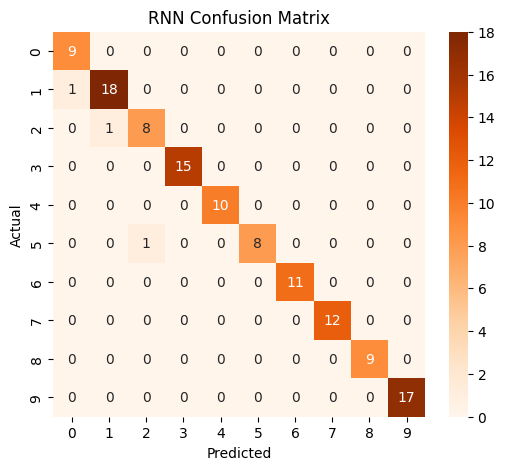

RNN Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       0.95      0.95      0.95        19
           2       0.89      0.89      0.89         9
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        10
           5       1.00      0.89      0.94         9
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00        17

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120



In [10]:
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test set
y_seq_pred_probs = model.predict(X_val)
y_seq_pred = np.argmax(y_seq_pred_probs, axis=1)

# Convert Y_val from one-hot encoded format to label format
Y_val_labels = np.argmax(Y_val, axis=1)

# Accuracy
rnn_accuracy = accuracy_score(Y_val_labels, y_seq_pred)
print("RNN Model Accuracy:", rnn_accuracy)

# Confusion Matrix
cm_rnn = confusion_matrix(Y_val_labels, y_seq_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rnn, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("RNN Confusion Matrix")
plt.show()

# Classification Report
print("RNN Classification Report:\n", classification_report(Y_val_labels, y_seq_pred))


### Check the real-time prediction

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model
from collections import deque

# Load trained LSTM model
model = load_model("lstm_sign_language_model_2")

# Define gestures
gestures = ["Hello", "Yes", "No", "Please", "ThankYou", "Mother", "Father", "Love", "Baby", "Sorry"]

# Initialize MediaPipe
mp_holistic = mp.solutions.holistic
cap = cv2.VideoCapture(0)

# Store the last 30 frames
sequence = deque(maxlen=30)

def extract_landmarks(image):
    """Extract pose and hand keypoints from an image"""
    with mp_holistic.Holistic(static_image_mode=False, min_detection_confidence=0.5) as holistic:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = holistic.process(img_rgb)

        # Extract keypoints
        pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]) if results.pose_landmarks else np.zeros((33, 3))
        left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21, 3))
        right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros((21, 3))

        return np.concatenate([pose.flatten(), left_hand.flatten(), right_hand.flatten()])

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # Extract keypoints
    keypoints = extract_landmarks(frame)
    sequence.append(keypoints)

    if len(sequence) == 30:  # Make prediction only if we have 30 frames
        input_sequence = np.expand_dims(np.array(sequence), axis=0)  # Reshape for model input
        prediction = model.predict(input_sequence)
        predicted_label = np.argmax(prediction)

        # Display prediction
        cv2.putText(frame, gestures[predicted_label], (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.imshow("Sign Language Recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 40ms/step


In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
import pickle
from tensorflow.keras import load_model

# Load trained Keras model
model = load_model("C:/Users/vithustennysan/Desktop/Static_Sign/sign_language_model.keras")

# Load label encoder to decode predictions
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.7)
mp_draw = mp.solutions.drawing_utils

def adjust_brightness(img, beta):
    """Adjust brightness using HSV color space."""
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] + beta, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# Create window with brightness trackbar
cv2.namedWindow('Hand Sign Recognition')
cv2.createTrackbar('Brightness', 'Hand Sign Recognition', 0, 100, lambda x: None)

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Mirror effect
    frame = cv2.flip(frame, 1)
    frame_height, frame_width = frame.shape[:2]
    
    # Convert to RGB for MediaPipe
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)
    
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw hand landmarks
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            
            # Extract ROI coordinates
            x_coords = [int(lm.x * frame_width) for lm in hand_landmarks.landmark]
            y_coords = [int(lm.y * frame_height) for lm in hand_landmarks.landmark]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            
            # Add padding and ensure within frame bounds
            padding = 20
            x_min = max(0, x_min - padding)
            y_min = max(0, y_min - padding)
            x_max = min(frame_width, x_max + padding)
            y_max = min(frame_height, y_max + padding)
            
            # Extract and adjust brightness of ROI
            roi = frame[y_min:y_max, x_min:x_max]
            brightness = cv2.getTrackbarPos('Brightness', 'Hand Sign Recognition') - 50
            if roi.size != 0:
                roi = adjust_brightness(roi, brightness)
                frame[y_min:y_max, x_min:x_max] = roi
            
            # Prepare landmarks for prediction
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
            
            # Convert to NumPy array and reshape for prediction
            landmarks = np.array(landmarks, dtype=np.float32).reshape(1, -1)
            
            # Make prediction using the TensorFlow model
            predictions = model.predict(landmarks)
            predicted_index = np.argmax(predictions)  # Get class index
            confidence = np.max(predictions)  # Get confidence score
            predicted_class = label_encoder.inverse_transform([predicted_index])[0]  # Convert back to label
            
            # Display prediction
            cv2.putText(frame, f"{predicted_class} ({confidence:.2f})", 
                        (x_min, y_min - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    cv2.imshow('Hand Sign Recognition', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
